In [1]:
%pylab notebook
from fontTools import ttLib
from fontTools.pens.basePen import BasePen
from font_helpers import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
tt = ttLib.TTFont("Lobster-Regular.ttf") # Load an existing font file
# tt = ttLib.TTFont("./RoyalBrand.ttf")
tt.ensureDecompiled()
cmap = tt["cmap"].getBestCmap()
gs = tt.getGlyphSet()
glyf = tt['glyf']

In [26]:
DENSITY = 0.1

def get_points(pt0, pt1, pt2):
    dx = pt2[0] - pt0[0]
    dy = pt2[1] - pt0[1]
    dist = sqrt(dx**2 + dy**2)
    N_POINTS = round(dist * DENSITY)
    if N_POINTS < 3:
        xs = array([pt0[0], (pt0[0] + pt2[0]) / 4 + pt1[0] / 2, pt2[0]])
        ys = array([pt0[1], (pt0[1] + pt2[1]) / 4 + pt1[1] / 2, pt2[1]])
        return xs, ys

    t = linspace(0, 1, N_POINTS)
    xs = (1 - t)**2 * pt0[0] + 2 * (1 - t) * t * pt1[0] + t**2 * pt2[0]
    ys = (1 - t)**2 * pt0[1] + 2 * (1 - t) * t * pt1[1] + t**2 * pt2[1]
    return xs, ys

/tmp/ipykernel_15751/831701291.py:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  close()


<IPython.core.display.Javascript object>


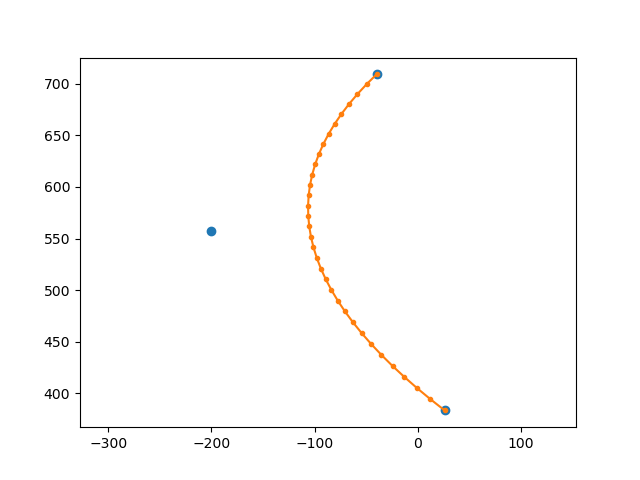

In [27]:
close()
plot()
axis("equal")

pt0, pt1, pt2 = (26.0, 383.5), (-200, 557), (-40, 709)
plot([pt0[0], pt1[0], pt2[0]], [pt0[1], pt1[1], pt2[1]], 'o')

xs, ys = get_points(pt0, pt1, pt2)
plot(xs, ys, '.-')

In [36]:
a = (1, 2)
b = (4, 5)
c = (1, 0)
pts = vstack((a, b))
print(pts + c)

[[2 2]
 [5 5]]


<IPython.core.display.Javascript object>


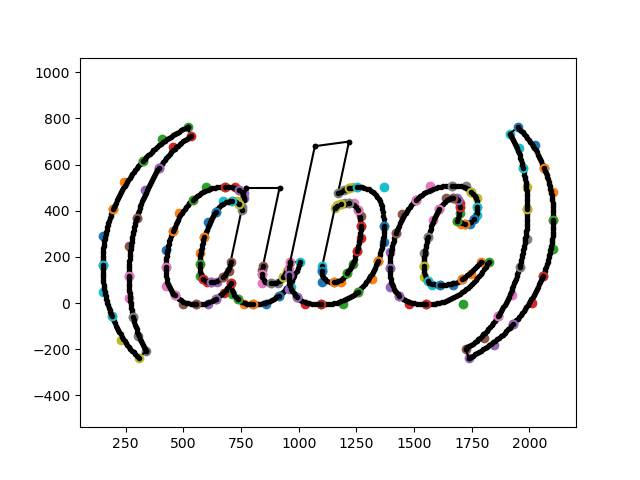

moveTo (150, 164)
qCurveToOne (150, 164) (150, 290) (195.5, 407.0)
qCurveToOne (195.5, 407.0) (241, 524) (325.0, 617.0)
qCurveToOne (325.0, 617.0) (409, 710) (519, 763)
lineTo (519, 763) (532, 723)
qCurveToOne (532, 723) (454, 677) (393.0, 584.0)
qCurveToOne (393.0, 584.0) (332, 491) (298.0, 369.0)
qCurveToOne (298.0, 369.0) (264, 247) (264, 118)
qCurveToOne (264, 118) (264, 23) (283.0, -60.5)
qCurveToOne (283.0, -60.5) (302, -144) (339, -208)
lineTo (339, -208) (306, -237)
qCurveToOne (306, -237) (231, -161) (190.5, -57.5)
qCurveToOne (190.5, -57.5) (150, 46) (150, 164)
closePath
moveTo (-13, 155)
qCurveToOne (-13, 155) (-13, 229) (16.5, 310.5)
qCurveToOne (16.5, 310.5) (46, 392) (104.5, 448.5)
qCurveToOne (104.5, 448.5) (163, 505) (244, 505)
qCurveToOne (244, 505) (285, 505) (305.0, 491.0)
qCurveToOne (305.0, 491.0) (325, 477) (325, 454)
lineTo (325, 454) (325, 447)
lineTo (325, 447) (336, 500)
lineTo (336, 500) (480, 500)
lineTo (480, 500) (408, 160)
qCurveToOne (408, 160) (404, 145

In [50]:
class MyPen(BasePen):
    def reset(self):
        self.last_point = (0, 0)
        self.bs = bytes()
        self.ce = CoordinateEncoder()
        self.cursor = [0, 0]
        self.lsb = 0
    
    def __init__(self, *args, do_plot=False, **kwargs):
        self.do_plot = do_plot
        self.reset()
        super(MyPen, self).__init__(*args, **kwargs)
    
    def _lineTo(self, pt):
        if self.do_plot:
            pts = vstack((self.last_point, pt))
            pts += self.cursor
            pts[:, 0] += self.lsb
            plot(pts[:, 0], pts[:, 1], 'k.-')
            print('lineTo', self.last_point, pt)
        self.bs += self.ce.encode(pt, T_LINETO << 4)
        self.last_point = pt
    
    def _moveTo(self, pt):
        if self.do_plot:
            print('moveTo', pt)
        self.last_point = pt
        self.first_point = pt
        self.bs += self.ce.encode(pt, T_GOTO << 4)
        
    def _qCurveToOne(self, pt1, pt2):
        pt0 = self.last_point
        if self.do_plot:
            pts = vstack((pt0, pt1, pt2))
            pts += self.cursor
            pts[:, 0] += self.lsb
            plot(pts[:, 0], pts[:, 1], 'o')

            xs, ys = get_points(pt0, pt1, pt2)
            plot(xs + self.cursor[0] + self.lsb, ys + self.cursor[1], 'k.-')
            
            print('qCurveToOne', pt0, pt1, pt2)
        
        self.bs += self.ce.encode(pt1, T_QBEZ << 4)
        self.bs += self.ce.encode(pt2)
        
        self.last_point = pt2
                
    def _closePath(self):
        if self.do_plot:
            print('closePath')
        if self.last_point != self.first_point:
            self._lineTo(self.first_point)
        
    def _endPath(self):
        print('endPath')

close()
plot()
axis("equal")

mp = MyPen(gs, do_plot=True)

for gn in ('parenleft', 'a', 'b', 'c', 'parenright'):
    g = gs[gn]
#     print(g.lsb, g.width, g._getGlyphAndOffset()[1])
# LSB-offset is already baked in by the BasePen
#     mp.lsb = -g.lsb
    g.draw(mp)
    mp.cursor[0] += g.width

# Generate code

In [51]:
mp = MyPen(gs, do_plot=False)

all_bs = bytes()
glyph_props = []

for c in arange(0x20, 0x20 + 95):
    name = cmap[c]
    g = gs[name]
    print(hex(c), chr(c), name)
    
    mp.reset()
    g.draw(mp)
    
    glyph_props.append({
#         "start_index": len(all_bs),
        "end_index": len(all_bs) + len(mp.bs),
        "adv_w": g.width,
#         "ofs_x": g.lsb
    })
    
    all_bs += mp.bs
    
len(all_bs)

0x20   space
0x21 ! exclam
0x22 " quotedbl
0x23 # numbersign
0x24 $ dollar
0x25 % percent
0x26 & ampersand
0x27 ' quotesingle
0x28 ( parenleft
0x29 ) parenright
0x2a * asterisk
0x2b + plus
0x2c , comma
0x2d - hyphen
0x2e . period
0x2f / slash
0x30 0 zero
0x31 1 one
0x32 2 two
0x33 3 three
0x34 4 four
0x35 5 five
0x36 6 six
0x37 7 seven
0x38 8 eight
0x39 9 nine
0x3a : colon
0x3b ; semicolon
0x3c < less
0x3d = equal
0x3e > greater
0x3f ? question
0x40 @ at
0x41 A A
0x42 B B
0x43 C C
0x44 D D
0x45 E E
0x46 F F
0x47 G G
0x48 H H
0x49 I I
0x4a J J
0x4b K K
0x4c L L
0x4d M M
0x4e N N
0x4f O O
0x50 P P
0x51 Q Q
0x52 R R
0x53 S S
0x54 T T
0x55 U U
0x56 V V
0x57 W W
0x58 X X
0x59 Y Y
0x5a Z Z
0x5b [ bracketleft
0x5c \ backslash
0x5d ] bracketright
0x5e ^ asciicircum
0x5f _ underscore
0x60 ` grave
0x61 a a
0x62 b b
0x63 c c
0x64 d d
0x65 e e
0x66 f f
0x67 g g
0x68 h h
0x69 i i
0x6a j j
0x6b k k
0x6c l l
0x6d m m
0x6e n n
0x6f o o
0x70 p p
0x71 q q
0x72 r r
0x73 s s
0x74 t t
0x75 u u
0x76 v v
0x7

11410

In [54]:
f = None
name = tt["name"].getBestFullName().lower()

print(f'''\
// -----------------------------------
//  {tt["name"].getBestFullName()} (.ttf font)
// -----------------------------------

static const uint8_t glyphs_{name}[{len(all_bs)}] = {{''', file=f)
print_table(all_bs, f=f)

print(f'''\
// GLYPH DESCRIPTION
static const glyph_dsc_t glyph_dsc_{name}[{len(glyph_props)}] = {{''', file=f)
for i, line in enumerate(glyph_props):
    print("    {" + ", ".join([f'.{k} = {v:5d}' for k, v in line.items()]) + f"}},  // '{chr(0x20 + i)}'", file=f)
print("};", file=f)

print(f'''
const font_t f_{name} = {{
    .units_per_em = {tt['head'].unitsPerEm},
    .n_glyphs = {len(glyph_props)},
    .glyphs = glyphs_{name},
    .glyph_dsc = glyph_dsc_{name},
}};
''', file=f)

# f.close()
# print('wrote', f.name)

// -----------------------------------
//  Lobster (.ttf font)
// -----------------------------------

static const uint8_t glyphs_lobster[11410] = {
 13,174,  2,219, 31,154, 21, 25,145,  0,231, 17, 85, 29, 76,  2,219,  9,142,  0, 74, 42, 33, 15,
 24, 23, 47, 23, 23,  5, 33, 37, 33,  7, 23, 23, 39, 23, 23,  2, 33, 34, 33,  3, 23, 23, 35, 23,
 24,  1, 33, 33, 33, 11, 23, 24, 43, 24, 23, 10, 33, 13,155,  2,240, 21,105, 19,110,232, 17, 70,
 31, 75,232,  5,157, 21,105, 19,110,232, 17, 70, 31, 75,232, 12,  1,225,  1,159, 19, 25,123, 21,
 94, 19, 15, 77, 17, 95, 19, 38,187, 17, 73, 31, 38,187, 17,129, 19, 38,187, 17, 73, 31, 38,187,
 17,105, 31, 15, 77, 21,105, 31, 25,123, 17,102, 31, 15, 77, 21,103, 31, 36,181, 21, 74, 19, 37,
181, 21,129, 31, 36,181, 21, 74, 19, 37,181, 21, 97, 19, 15, 77, 17, 97,  1, 74, 17,128, 19, 25,
123, 21,128, 31, 25,123, 12,  1,181,  2,133, 42, 24, 11, 11, 17, 43, 10, 16, 11, 20,  8, 19, 56,
244, 23, 23, 25, 39, 39, 41,  7, 24, 32, 39, 25, 31,  7, 17, 39, 39, 16, 3

  3, 57, 61, 35, 58, 60,  3, 55, 44, 23,  1,  3, 47, 18,  7, 15, 24,  6, 47, 25,  5,  5, 22, 37,
 25,  7, 35,  6, 39, 35,  6,  7,  9,  2, 31, 81,233, 21, 64, 19, 49,232, 47, 35, 13, 15, 28, 34,
 23,  3,  2, 39, 16, 28,  2, 27, 34, 39,  3, 30, 30, 35, 30, 30,  3, 47,  9, 15, 15,141, 42, 63,
 15, 36, 38, 47, 36, 39,  5, 58, 37, 61,  7, 10, 51, 35, 41,  5,  3, 25, 25, 35, 24, 24,  2, 39,
 34, 35,  7, 21, 20, 39, 21, 20,  5, 35, 37, 58, 15, 37, 52, 47, 37, 52, 10, 81, 42, 69, 11, 29,
 38, 43, 29, 37,  1, 52, 33, 53,  3, 78, 45, 27, 13,  9, 29, 77,  2,222, 39,113, 13,  5, 55, 37,
 91, 15, 83, 28, 39,  2, 22,  2, 11, 34, 52,  3, 28, 32, 35, 27, 32,  1, 60, 33, 23, 11, 32,  5,
 43, 32,  5, 11, 29,  6, 43, 25,  5, 11, 26,  4, 19, 40,181, 47, 65, 31,  5, 59, 37, 82,  7, 48,
 55, 39, 47, 56,  2, 95, 34, 81,  3, 35, 62, 35, 36, 62,  3, 64, 34, 35, 65, 35,  1, 84, 33, 88,
 11, 47, 38, 43, 47, 38, 10, 70, 13, 16,  1,  3, 42,134, 15, 46,113, 47, 47,112, 15, 80, 66, 47,
 80, 65,  5, 96, 37, 66,  7, 3

 62, 60, 47, 62, 61,  5, 94, 37,128,  2,160, 18,  1, 39,  3,  1,  5,  8, 37, 33, 15, 43, 17, 47,
 43, 18, 15, 35, 25, 23,  9, 27, 35, 29, 31,  3, 47, 21, 35, 46, 22,  3, 55,  9, 35,  8, 91,  3,
 33, 68, 35, 33, 68,  3, 52, 37, 35, 52, 37,  1, 61, 33, 74, 11, 43, 38, 43, 43, 38, 10, 82, 14,
  1, 46,140, 43, 27,  6, 10, 36, 42, 41, 15, 31, 13, 43,  2, 33, 11,  8, 13, 43,  8, 12,  1, 20,
 33, 33,  3, 31, 48, 35, 31, 48,  3, 19, 67, 35, 19, 67,  2, 51, 34, 48,  7, 11, 17, 39, 11, 16,
  5, 29, 37, 24, 15, 24, 28, 47, 24, 27, 15, 18, 47, 47, 18, 48, 15,  8, 58, 13, 76,  2, 25, 21,
144, 19, 16, 75, 47, 50, 43,  5, 67, 37, 56,  7, 33, 37, 39, 33, 37,  2, 84, 34, 79,  3, 23, 80,
 35, 23, 81,  3, 55, 57, 35, 55, 56,  1, 90, 33, 64, 11, 21, 36, 19, 52,244, 19,151, 36, 29,167,
  2, 25,  7,230,187, 42, 83,  1, 50, 33, 18,  3, 18, 13, 35, 19, 13,  3, 14, 23, 25, 59,  0,104,
 39,  8, 23,  5, 30, 37, 48, 15, 32, 45, 47, 31, 45, 15, 15, 63, 47, 14, 62, 10, 54, 15,239, 49,
 35, 51, 55,  1, 68, 33, 57, 1